# Social Networks and Text Analysis - Assessed practical exercises

# Student number: 670044362
# Candidate number: 087074

In [1]:
# import required functions
import networkx as nx 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns 
import random
from pylab import rcParams
import collections
import powerlaw
import scipy.stats as stats
from scipy.stats import lognorm, kstest
import community as community_louvain
from scipy.stats import lognorm
import networkx as nx
from pylab import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
import operator
from collections import defaultdict
import random

# Magic functions for setting up the matplotlib and increase the resolution of the plots
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Part 1: Analyze a Network

## 1a) Load the Network

In [2]:
#Read the edges file:
file=open("ia-enron.edges", 'r')
Gx = nx.read_edgelist(file, nodetype=int) # save the edgelist as Gx

## 1b) Plot the Network Adjacency Matrix

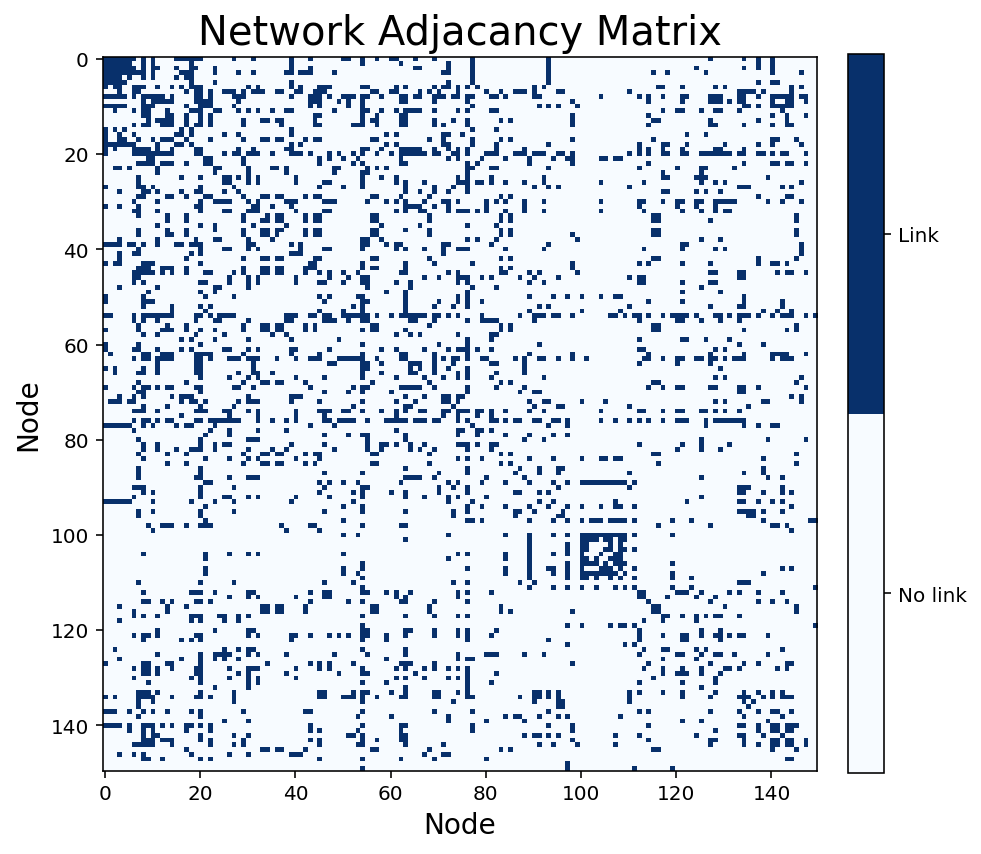

In [3]:
A = nx.to_numpy_matrix(Gx) # obtain the adjacancy matrix of the graph 

fig = plt.figure(figsize=(7,7))
cmap = cm.get_cmap('Blues', 2)
plt.imshow(A, cmap=cmap) # create a heatmap of the adjacancy matrix

cbar = plt.colorbar(fraction=0.046, pad=0.04) # add a colorbar
loc = [0.25, 0.75]
cbar.set_ticks(loc)
cbar.set_ticklabels(['No link','Link'])

plt.title('Network Adjacancy Matrix', size=20) # add titles and labels
plt.xlabel('Node', size=14)
plt.ylabel('Node', size=14) 
plt.show()

## 1c) Plot the Degree distribution

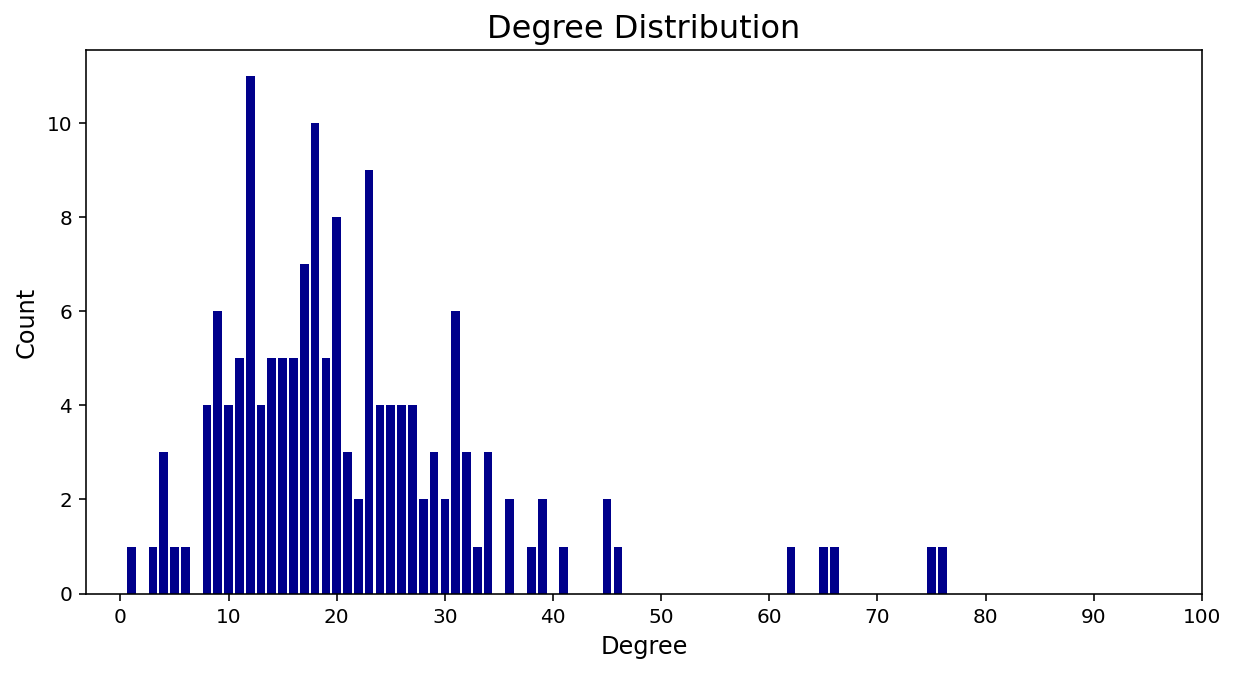

In [4]:
# store the degree of each node in a list, in descending order
degree_sequence = sorted([d for n, d in Gx.degree()], reverse=True)
degreeCount = collections.Counter(degree_sequence) # create a distionary of degree frequency
degree, count = zip(*degreeCount.items()) # creates lists of the keys and values of the dictionary 

fig = plt.figure(figsize=(10,5)) # create a figure
ax = plt.gca()
plt.bar(degree, count, width=0.80, color='darkblue') # bar chart of degree frequency

# set plot title, labels and ticks
plt.title("Degree Distribution", size=16)
plt.ylabel("Count", size=12)
plt.xlabel("Degree", size=12)
plt.xticks(np.arange(0,110,10))
plt.show()

## 1d) Plot the Degree distribution 2

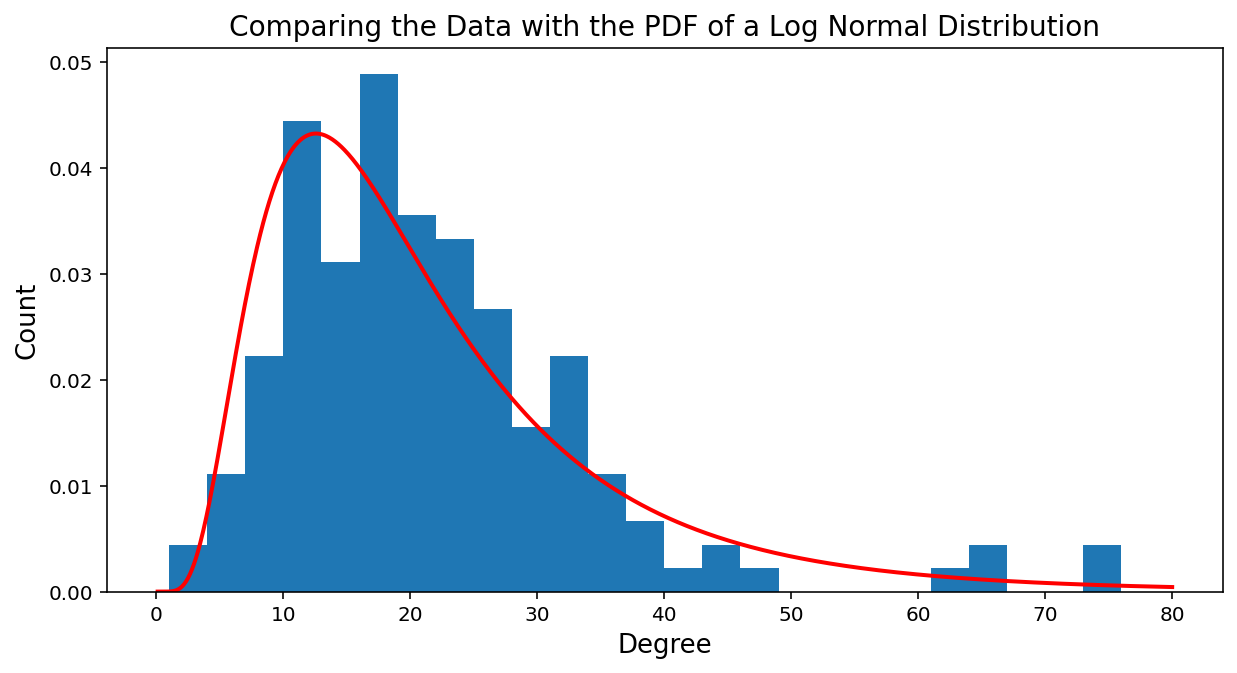

I have performed a Kolomoropv-Smirnov test under the null hypothesis that the degree sequence is drawn from a 
log normal distribution with a mean of 2.9 and a standard deviation of 0.61. The altrernative hypothesis 
is that the degree sequence is drawn from a different distribution. The signifance level is taken to be 5%.

The p-value of the Kolomoropv-Smirnov test is 0.92. This value is insignificant at a 5% significance level. 
Therefore, the null hypothesis can be accepted and we can conclude that the samples are drawn from the same 
distribution.


In [5]:
# calculate the mean and standard deviation of the log of the degree distribution
mu = np.mean(np.log(degree_sequence))
sigma = np.std(np.log(degree_sequence))

# use these parameters to calculate the pdf of a a log normal over a suitable range of x values
x = np.linspace(0.1, 80, 1000)
pdf = (np.exp(-(np.log(x)-mu)**2/(2*sigma**2))/(x*sigma*np.sqrt(2*np.pi))) # pdf of the log normal

fig = plt.figure(figsize=(10,5)) # create a figure
ax = plt.gca()

plt.plot(x, pdf, linewidth=2, color='r') # plot the pdf of the log normal
plt.hist(degree_sequence, bins=25, density=True) # plot a histogram of the degree sequence

# set plot title, labels and ticks
plt.title("Comparing the Data with the PDF of a Log Normal Distribution", size=14)
plt.ylabel("Count", size=13)
plt.xlabel("Degree", size=13)
plt.xticks(np.arange(0,110,10))
plt.axis('tight')
plt.show()


# perform a Kolomoropv-Smirnov test
params = stats.lognorm.fit(degree_sequence) # obtain the suitable parameters of the degree sequence
statistic, pvalue = stats.kstest(degree_sequence, 'lognorm', params) # apply the test
p = pvalue.round(2) # round the p-value

# Analyse the results of the Kolomoropv-Smirnov test
print('''I have performed a Kolomoropv-Smirnov test under the null hypothesis that the degree sequence is drawn from a 
log normal distribution with a mean of ''' + str(mu.round(2)) + ''' and a standard deviation of ''' + str(sigma.round(2)) + '''. The altrernative hypothesis 
is that the degree sequence is drawn from a different distribution. The signifance level is taken to be 5%.
''')
print('''The p-value of the Kolomoropv-Smirnov test is ''' + str(p) + '''. This value is insignificant at a 5% significance level. 
Therefore, the null hypothesis can be accepted and we can conclude that the samples are drawn from the same 
distribution.''')

## 1e) Is the Network you are analyzing Assortative or Disassortative?

In [6]:
assort_coef = nx.degree_assortativity_coefficient(Gx) # calculate the assorativity coefficient
print('The assortativity coefficient of the network is ' + str(assort_coef.round(3)) + '.')

The assortativity coefficient of the network is -0.045.


The assortativity of a network is a measure of the likelihood of the nodes in a network to be connected to nodes of a similar degree. Assortativity is usually measured by the assortativity coefficient, given by:
$$
r = \frac{\sum_{jk}jk(e_{jk}-q_jq_k)}{\sigma_q^2}
$$
- $q_k$ is the number of edges leaving the node, other than the one that connects the pair
- $e_{jk}$ refers to the joint probability distribution of the remaining degrees of the two vertices
- $\sigma_{q}^2$ is the variance of the degree distribution

The assortativity coefficient $r$, is a measure of correlation, therefore $-1 ≤ r ≥ 1$. Positive values of $r$ indicate that nodes are more likely to be connected to nodes of a similar degree, $r=1$ indicates perfect assortativity. Negative values of $r$ indicate that nodes are more likely to be connected to nodes of different degree, with $r=−1$ indicating perfect dissasortativity. When $r =0$, the network is neither assortative or dissasortative. 

As shown above, the assortativity coefficient of the network is $-0.045$. Therefore, the network is slightly dissasortative. 

## 1f) Fitting

In [7]:
def Plot_pdf_CCDF(Data):
    fit = powerlaw.Fit(Data) # use the power law package to fit a power law equation to the data
    fig = fit.plot_pdf(color='b', linewidth=2) # create a graph and plot the PDF of the data
    fit.power_law.plot_pdf(color='b', linestyle='dashed', ax=fig) # plot the PDF of the power law fit on the graph
    fit.plot_ccdf(color='r', linewidth=2, ax=fig) #<-- Plot the CCDF of the data on the same graph
    fit.power_law.plot_ccdf(color='r', linestyle='dashed', ax=fig) #  plot the CCDF of the power law fit
    
    # create a legend, title and labels
    plt.legend(['Data pdf', 'fit PDF', 'Data CCDF', 'fit CCDF'], fontsize = 'x-large')
    plt.xlabel('Degree Frequency', fontsize = 'x-large')
    plt.ylabel('p(X), p(X≤x)', fontsize = 'x-large')
    plt.show()

Calculating best minimal value for power law fit


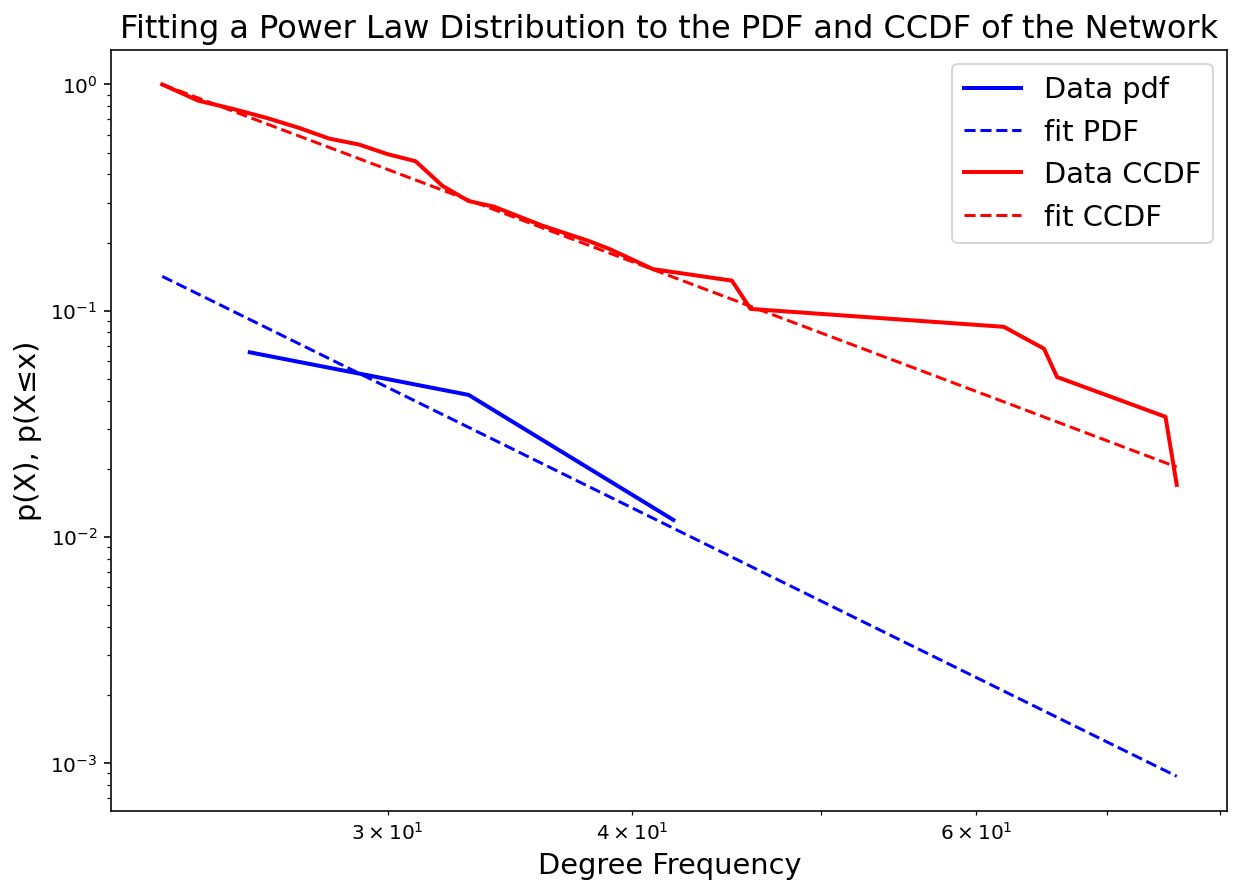

In [8]:
import warnings # ignore warnings 
warnings.filterwarnings('ignore')

fig = plt.figure(figsize=(10,7)) # create a figure of suitable size 
ax = fig.add_subplot(111)
ax.set_title('Fitting a Power Law Distribution to the PDF and CCDF of the Network', fontsize = 16)
Plot_pdf_CCDF(list(degree_sequence)) # apply the Plot_pdf_CCDF function onto the data

# Part 2: Centrality and Community Detection

## 2a) Centralities

The degree centrality, defined as the degree of a node, is the simplest centrality measure. The degree of a node $i$ is calculated by summing over the $i$th row in the adjacancy matrix $A$, thus counting the number of connections of the node.
$$
c_i = \sum_{j=1}^{n} A_{i,j}
$$

The degree centrality assigns equal value to each connection. This makes the degree centrality a useful centrality measure when reviewing the popularity of a user in a social network. For example, someone's popularity on twitter can be measured by the indegree of their node, i.e. the number of followers that they have.

The eigenvector centrality on the other hand, assigns importance to connections by scaling an edge according to the degree of the node that the edge connects to. By doing so, nodes connected to important nodes are assigned more importance. 
$$
c_i = \frac{1}{\lambda}\sum_{j=1,N} a_{i,j}c_j
$$
- $\lambda$ is a constant eigenvector
- $a_{i,j}$ is the $i,j$ component of the adjacancy matrix, $A$
- $c_j$ is the degree of the connecting node

Eigenvector centrality measures the influence of a node within a network. Therefore, it can be used to analyse someone's power within a social network. This is because, having influence over important people within a social network makes someone powerful. 

## 2b.i) Closeness Centrality

In [9]:
def centrality_closeness(G): 
    closeness_dict = {} # create a dictionary used to store the cenrtality of each node
    for i in G.nodes(): # iterate over the nodes of G
        lengths = []
        for j in G.nodes(): # iterate over the nodes of G
            path = nx.shortest_path(G, source=i, target=j) # calculate the shortest path between i and j
            lengths.append(len(path)-1) 
        closeness = (len(G.nodes())-1)/sum(lengths) # apply centrality formula (the average shortest path)
        closeness_dict[i] = closeness # add the closeness centrality of each node to the dictionary
    return closeness_dict

## 2b.ii) Comparison Centralities

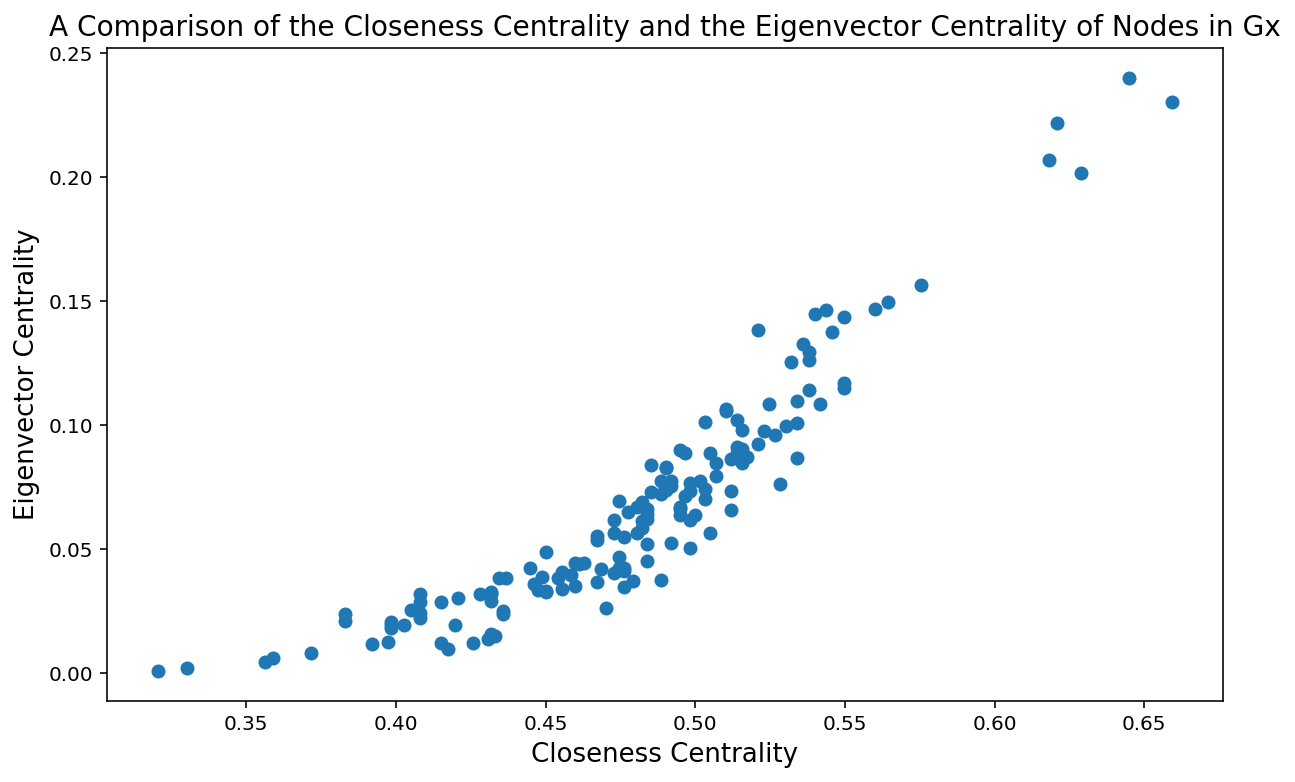

In [10]:
# use the centrality_closeness function to obatin closeness centrality of each node 
close_values = list(centrality_closeness(Gx).values()) 
eig_values = list(nx.eigenvector_centrality(Gx).values()) # calculate the eigenvector centrality of each node

fig = plt.figure(figsize=(10,6)) # create a figure
ax = plt.gca()
ax.scatter(close_values, eig_values) # plot the data

# set plot title and labels
plt.title("A Comparison of the Closeness Centrality and the Eigenvector Centrality of Nodes in Gx", size=14)
plt.xlabel("Closeness Centrality", size=13)
plt.ylabel("Eigenvector Centrality", size=13)
plt.axis('tight')
plt.show()

In [11]:
slope, intercept, rvalue, pvalue, stderror = linregress(close_values, eig_values)
print('''The correlation coefficient between the closeness centrality and the eigenvector centrality is ''' + str(slope.round(3)) + 
'''.''' ''' 
The p-value is ''' + str(pvalue.round(5)) + ''' (5 sf), therefore the correlation between the two centrality measures is 
statistically significant.''')

The correlation coefficient between the closeness centrality and the eigenvector centrality is 0.76. 
The p-value is 0.0 (5 sf), therefore the correlation between the two centrality measures is 
statistically significant.


The centrality of a node is a measure of its importance in a network. The definition of importance is highly context specific, therefore there are a number of different centrality measures to encompass the full scope of the word. Althought the different centrality measures will produce slightly different results, the results will be strongly correlated as they measure the same fundamental idea, just in slightly different ways.

For example, the closeness centrality and the eigenvector centrality are correlated because nodes that are important to the flow of information will be connected to highly connected nodes.

## 2c) Centrality Measure

In [12]:
degree_dict = nx.degree_centrality(Gx) # calculate the degree centrality of each node
max_node = max(degree_dict.items(), key=operator.itemgetter(1))[0] # node with maximum degree
print('The node with the highest degree is node ' + str(150) + '.')

The node with the highest degree is node 150.


I have chosen to hire the person represented by node 150 as they have the highest number of connections in the network (highest degree centrality). Each time this person posts on the social media platform, more people see their posts than anyone else in the network. Therefore, choosing this person to advertise the product will enable us to reach the largest number of consumers that we can. 

## 2d) Influencer

In [13]:
def Draw_ego_network(G, pos, ego_node, n):
    keepers = [] # as the interaction distance = 2, some nodes are not displayed
    for i in G.nodes(): # if the shortest path from the ego node to any node is more than 2 -> do not display
        shortest_path = nx.shortest_path(G, source=ego_node, target=i)
        if len(shortest_path) <= n+1: 
            keepers.append(i) # only keep required nodes

    H = nx.subgraph(Gx, keepers) # iterate over nodes with the suitable interaction distance
    colours = []
    for i in keepers: # set the colour of the node according to it's interaction distance
        colours.append(len(nx.shortest_path(Gx, source=150, target=i))-1)
    
    fig = plt.figure(figsize=(10,6)) # create a figure
    
    # add a colorbar
    cmap=cm.get_cmap('Blues', 3) # only three different node types -> three colours
    sm = plt.cm.ScalarMappable(cmap=cmap)
    cbar = plt.colorbar(sm)
    loc = [1/6, 0.5, 5/6] # set the locations of colour labels
    cbar.set_ticks(loc)
    cbar.set_ticklabels(['0','1', '2']) # add colour labels
    cbar.ax.set_ylabel('Interaction Distance')
    cbar.ax.tick_params(length=0)
    
    # draw the network 
    nodes = nx.draw_networkx_nodes(H, pos, node_color=colours, node_size=50, cmap=cmap)
    options = {"node_size": 600, "node_color": 0}
    nx.draw_networkx_nodes(H, pos, nodelist=[hub_node], **options, cmap=cmap)
    
    edges = nx.draw_networkx_edges(H, pos, edge_color = 'grey', alpha=0.3)
    
    labels = {150:'Ego'}
    nx.draw_networkx_labels(H,pos,labels,font_size=11,font_color='k')
    
    # Show the plot without the x/y axis
    plt.axis('off')
    plt.show()
    
    return plt.show()

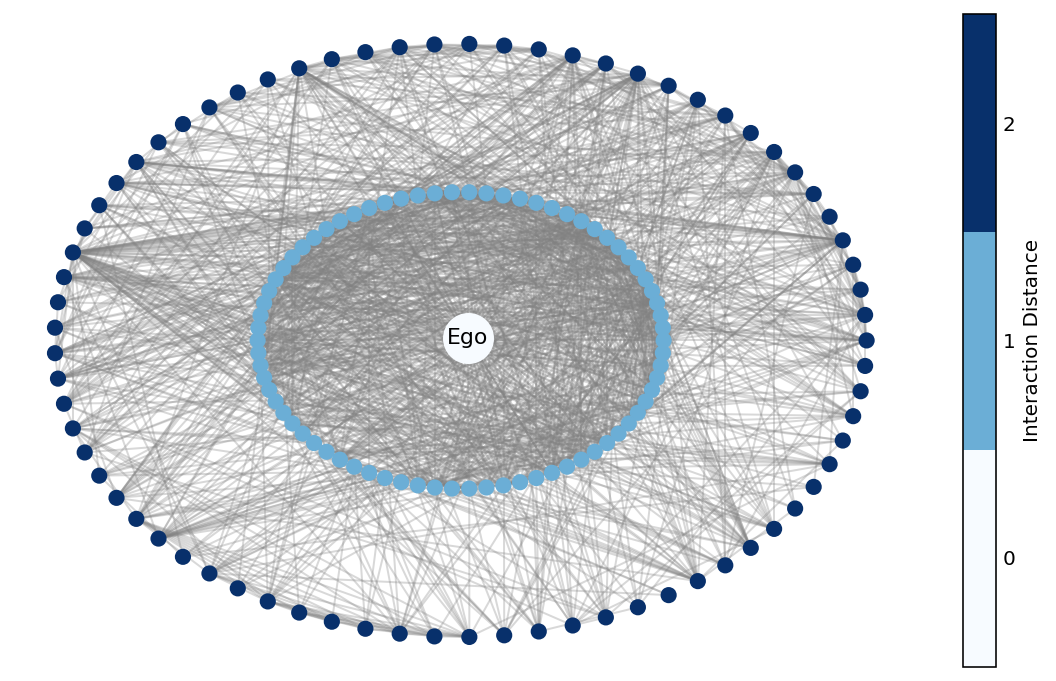

In [14]:
# testing my function - making useful coordinates and then plotting

# create a function that gets the position of nodes in a circle
def get_coordinates_in_circle(n, val):
    return_list = []
    for i in range(n): # iterate over the number of nodes
        theta = float(i)/n*2*np.pi # radians
        x = np.cos(theta)*val # x value
        y = np.sin(theta)*val # y value
        return_list.append((x,y)) # add the coordinates to a list
    return return_list

hub_node = 150
one_out = [] # nodes that have interction distance of 1
two_out = [] # nodes that have interction distance of 2

for i in Gx.nodes(): # iterate over the nodes of the network
    shortest_path = nx.shortest_path(Gx, source=150, target=i)
    if len(shortest_path) == 2: # add nodes that have interction distance of 1
        one_out.append(i)
    if len(shortest_path) == 3: # add nodes that have interction distance of 2
        two_out.append(i)


pos = nx.spring_layout(Gx) # initiate the node positions as spring layout
circular_positions_one = get_coordinates_in_circle(len(one_out), 1) # run the circular function
circular_positions_two = get_coordinates_in_circle(len(two_out), 2)    

i = 0
for p in pos.keys():
    if p in one_out:
        pos[p] = circular_positions_one[i] # update positions of nodes that have interction distance of 1
        i += 1
i = 0
for p in pos.keys():
    if p in two_out:
        pos[p] = circular_positions_two[i] # update positions of nodes that have interction distance of 2
        i += 1

Draw_ego_network(Gx, pos, 150, 2) # run the function using the cicular positions

## 2e) Community Detection and Centrality

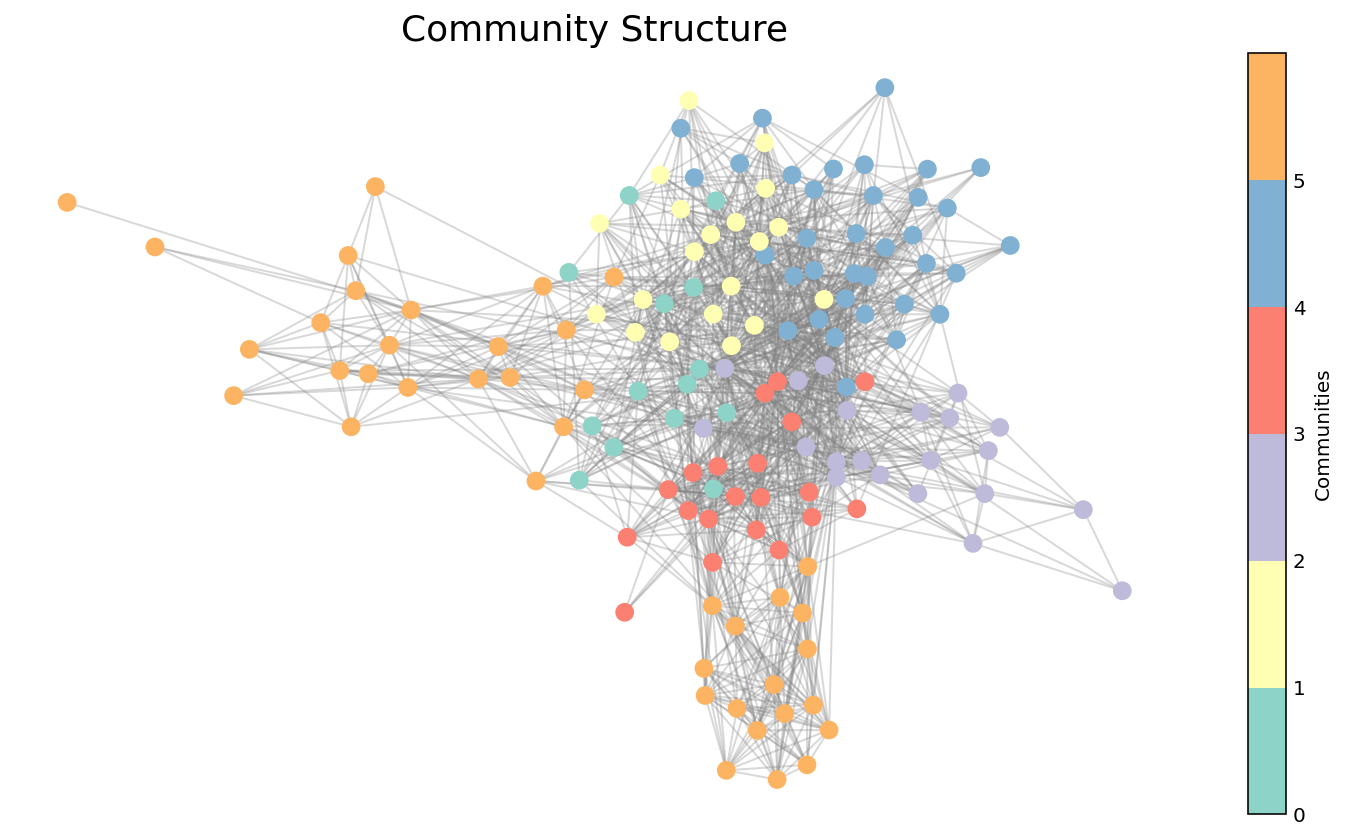

In [15]:
# I am using the Louvain method for community detection
clusters = np.array(list(set(community_louvain.best_partition(Gx).values()))) # obtain clusters

fig = plt.figure(figsize=(13,7)) # Create a figure

# create the network
pos = nx.spring_layout(Gx) # layout of nodes
nodes = nx.draw_networkx_nodes(Gx, pos, node_size=70, cmap=mcolors.ListedColormap(plt.cm.Set3(clusters)), 
                               node_color=list(community_louvain.best_partition(Gx).values()),
                               nodelist=list(community_louvain.best_partition(Gx).keys()))
edges = nx.draw_networkx_edges(Gx, pos, edge_color = 'grey', alpha=0.3) # grey edges for better visualisation

plt.title('Community Structure', size=18) # add a title

# create a color bar
cbar = plt.colorbar(nodes,ticks=range(0,len(clusters)), label='Communities') # Add a colour bar to act as a legend
cbar.ax.tick_params(length=0) # remove ticks of the colour bar
cbar.set_ticklabels(list(set(community_louvain.best_partition(Gx).values()))) # Adds community labels


#nodes.set_clim(-0.5, len(clusters)-0.5)

# Show the plot without the x/y axis
plt.axis('off')
plt.show()

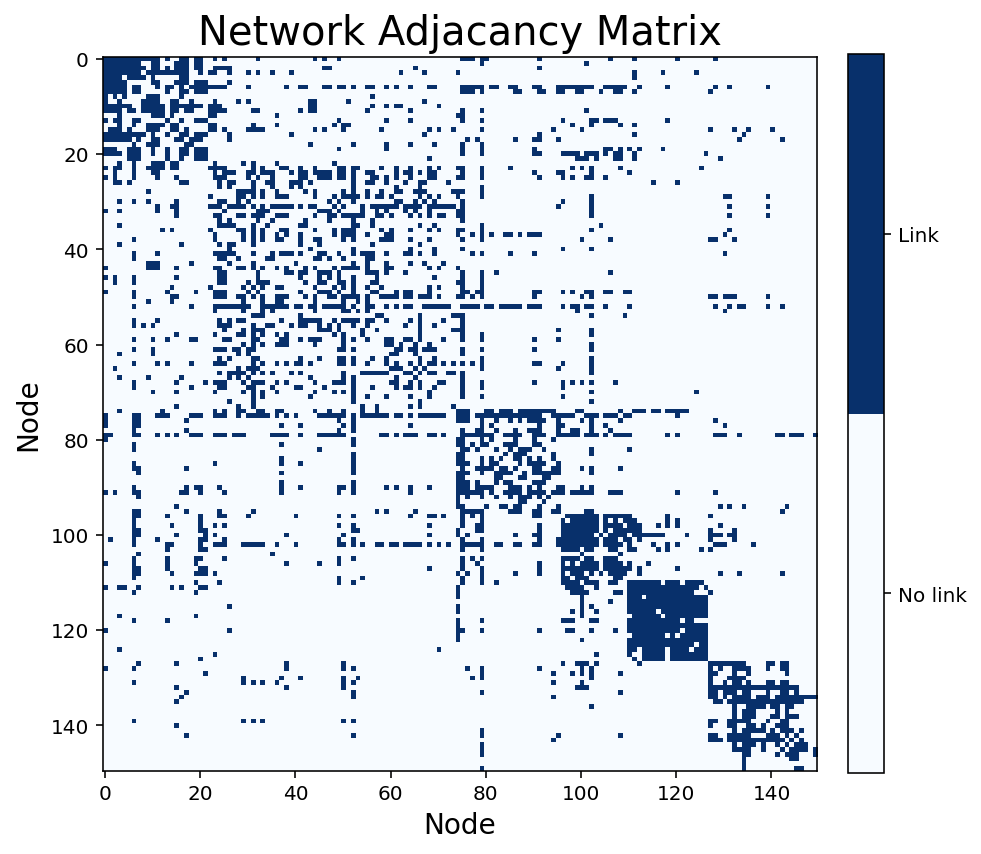

In [16]:
louvain_community_dict = community_louvain.best_partition(Gx) # obtain clusters as a dictionary
# obtain the values of the dioctionary as a list
louvain_comms = defaultdict(list)
for node_index, comm_id in louvain_community_dict.items():
    louvain_comms[comm_id].append(node_index)
louvain_comms = louvain_comms.values() 
node_order = [node for comm in louvain_comms for node in comm]

A = nx.to_numpy_matrix(Gx, dtype=np.bool, nodelist=node_order) # rearrange the matrix into the order of the communities

# display the adjacancy matrix
fig = plt.figure(figsize=(7,7)) # create a figure
cmap = cm.get_cmap('Blues', 2)
plt.imshow(A, cmap=cmap) # create a heatmap of the adjacancy matrix

cbar = plt.colorbar(fraction=0.046, pad=0.04) # add a colorbar
loc = [0.25, 0.75]
cbar.set_ticks(loc)
cbar.set_ticklabels(['No link','Link'])

plt.title('Network Adjacancy Matrix', size=20) # add titles and labels
plt.xlabel('Node', size=14)
plt.ylabel('Node', size=14) 
plt.show()

## 2f) Find and Plot the Longest Shortest Path

In [17]:
def plot_long_shortest(G):
    longest = 0
    for i in Gx.nodes(): # iterate over all possible paths to find the longest shortest path
        for j in Gx.nodes():
            path = nx.shortest_path(Gx, source=i, target=j)
            if len(path) > longest: # store the longest shortest path
                longest = len(path)
                longest_path = path
    path_edges = list(zip(longest_path,longest_path[1:])) # store the edges of the longest shortest path
    
    fig = plt.figure(figsize=(10,6)) # create a figure
    
    # plot the network
    pos = nx.spring_layout(Gx) # layout of the network
    #nx.draw(Gx, pos, node_color='b', with_labels=False, node_size=70) # plot the entire network
    
    
    nx.draw_networkx_nodes(G, pos, node_color='k', node_size=30, cmap=cmap)
    nx.draw_networkx_edges(G, pos, edge_color = 'grey', alpha=0.4) # grey edges for better visualisation
    
    
    # add distinction to the longest shortest path
    nx.draw_networkx_nodes(Gx,pos, nodelist=longest_path, node_color='r', label=True)  # large red nodes
    nx.draw_networkx_edges(Gx,pos, edgelist=path_edges, edge_color='r', width=7)  # thick red edges
    labels = {i:i for i in longest_path} # add labels to the shortest path 
    nx.draw_networkx_labels(Gx, pos, labels, font_size=9, font_color='white')
    plt.axis('off') # remove axis
    
    # print out the shortest path to the user
    print('The shorted path in the network is along the nodes: ' + str(list(labels.values())))
    return plt.show()

The shorted path in the network is along the nodes: [151, 66, 53, 135, 144]


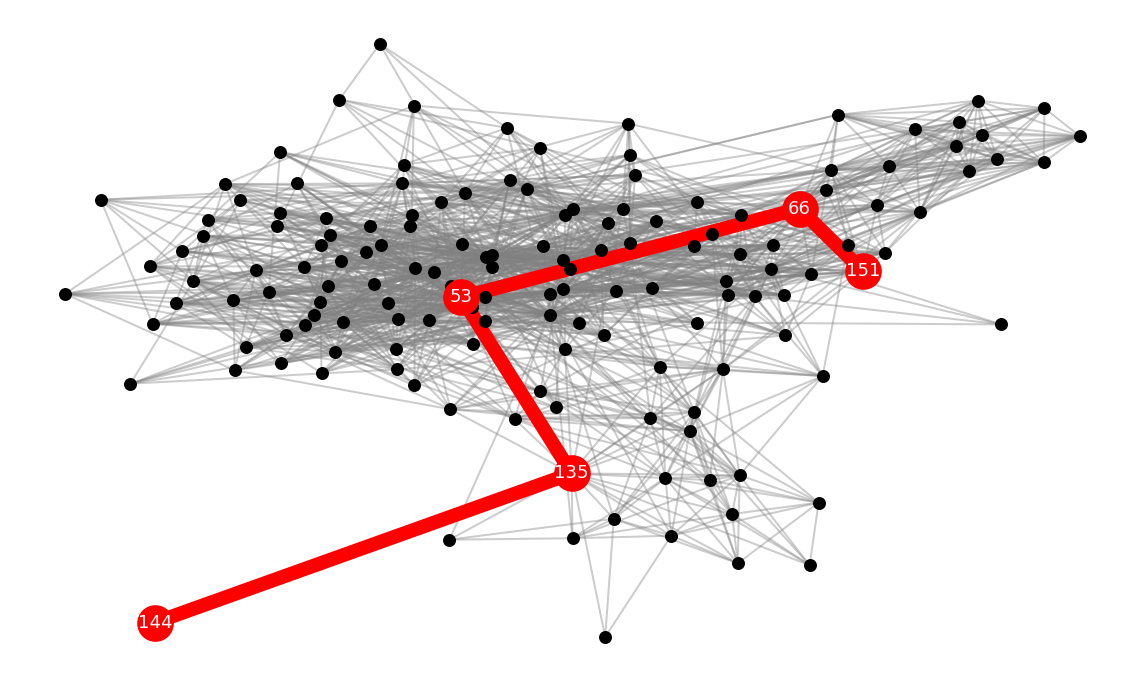

In [18]:
plot_long_shortest(Gx) # run the function

# Part 3: SI Model

## 3a) SI model

In [19]:
def SI_model(G, initial_infecteds, beta, t_simulation):
    """G: the graph that the disease infects
       initial_infecteds: a list of nodes that are intially infected
       beta: transmission probability
       t_simulation: number of iterations of the disease in the system"""

    for u in G.nodes():
        G.nodes[u]["state"] = 'S' # each node is susceptible (S) to the disease
        G.nodes[u]["neighbours"] = [n for n in G.neighbors(u)] # each node is influenced by its direct neighbours
        G.nodes[u]["new_state"] = 'stay_S' # this governs changes in the state of nodes
        
    for u in initial_infecteds:
        G.nodes[u]["state"] = 'I' # initialise the infected (I) nodes
        G.nodes[u]["new_state"] = 'stay_I' # initialise infected nodes stay as staying infected

    # create a dictionary to store the state of the system over time
    state_over_time = {}
    # save the initial state of the system at t=0 in the dictionary
    state = [] 
    for i in G.nodes():
        state.append(G.nodes[i]["state"]) # append each node state to a list 
    state_over_time[0] = state # save the list to the dictionary

    # running the simulation
    for t in range(1,t_simulation+1): # over t_simulation iterations
        for u in G.nodes: # iterate over each node in the system
            if G.nodes[u]["state"] == 'S': #if susceptible
                for n in G.nodes[u]["neighbours"]:
                    if G.nodes[n]["state"] == 'I': # if neighbour is infected
                        # node becomes infected according to the transmission probability
                        if np.random.rand() < beta:
                            G.nodes[u]["new_state"] = 'become_I' # the node needs to be changed to infected
        # alter the state of the nodes
        for u in G.nodes:
            if G.nodes[u]["new_state"] == 'become_I':
                G.nodes[u]["state"] = 'I'
                G.nodes[u]["new_state"] = 'stay_I' # nodes remain infected

        # save the state of the system to a list
        state = [] 
        for i in G.nodes():
            state.append(G.nodes[i]["state"])
        state_over_time[t] = state
        
    return state_over_time # return the state of the system over time

In [20]:
"""Using the SI_model, the system is evaluated 100 times under different starting nodes. The average number of 
   susceptible and infected nodes at each time step of the system is stored."""

num_simulations = 100 # number of times the system will be run in order to obtain an average
# these are the inputs into the SI_model
beta = 0.01
t_simulation = 300
    
# the number of S and I nodes over time will be saved to these lists, each time we run the model
all_susceptible = []
all_infected = []

for i in range(0,num_simulations): # iterate over the number of times we want to run the model
    initial_infecteds = random.sample(Gx.nodes(), 3) # choose three random starting nodes
    SI_one_iter = SI_model(Gx, initial_infecteds, beta, t_simulation) # # run the model
    # count the number of S and I nodes at each iteration of the model
    infected = []
    susceptible = []
    for i in SI_one_iter.values(): 
        infected.append(i.count('I'))
        susceptible.append(i.count('S'))
    # store the model dynamics
    all_susceptible.append(susceptible)
    all_infected.append(infected)

# obtain an average of the number of S and I nodes at each iteration
average_susceptibleSI = []
average_infectedSI = []
for j in range(0,len(all_susceptible[0])): # iterate over each time iteration 
    total_susceptible = 0 
    total_infected = 0
    for i in range(len(all_susceptible)): # iterate over each model
        total_susceptible += all_susceptible[i][j] 
        total_infected += all_infected[i][j]
    average_susceptibleSI.append(total_susceptible/len(all_susceptible)) # divide by number of models to obtain average
    average_infectedSI.append(total_infected/len(all_infected))

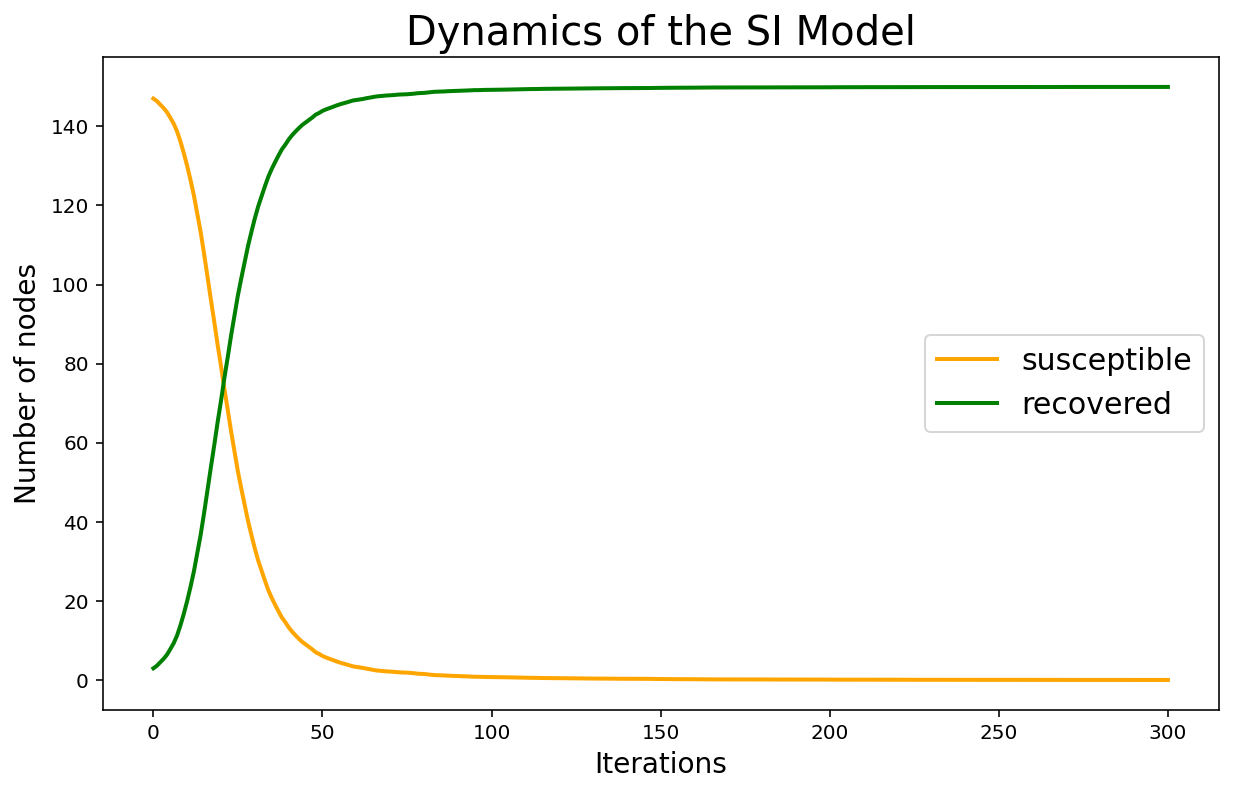

In [21]:
fig = plt.figure(figsize=(10,6))

plt.plot(average_susceptibleSI, linewidth=2.0, c='orange', label='susceptible')
plt.plot(average_infectedSI, linewidth=2.0, c='green', label='recovered')

plt.legend(loc=5, prop={'size': 15})
plt.title('Dynamics of the SI Model', size=20) # add titles and labels
plt.xlabel('Iterations', size=14)
plt.ylabel('Number of nodes', size=14) 

plt.show()

## 3b) SIR Model

In [22]:
def SIR_model(G, initial_infected, beta, t_simulation, recovery_time):
    """This model operates similarly to SI_model. The difference is that nodes are able to recover from an illness
       and are then immune.
       recovery_time: number of days required until node is recovered/immune"""
    
    # intialise the state of the nodes
    for u in G.nodes():
        G.nodes[u]["state"] = 'S' # each node is susceptible (S) to the disease
        G.nodes[u]["TimeInfected"] = -1 # because each node has not been infected
        G.nodes[u]["neighbours"] = [n for n in G.neighbors(u)] # each node is influenced by its direct neighbours
        G.nodes[u]["new_state"] = 'stay_S' # this governs changes in the state of nodes
 
    # for the nodes that are initally set to be infected, we change their state and their TimeInfected
    for u in initial_infecteds:
        G.nodes[u]["state"] = 'I'
        G.nodes[u]["new_state"] = 'stay_I'
        G.nodes[u]["TimeInfected"] = 0

    # create dictionaries to store the state and time infected of each node
    state_over_time = {}
    time_over_time = {}
    # save the initial state of the system at t=0
    state = []
    for i in G.nodes():
        state.append(G.nodes[i]["state"])
    state_over_time[0] = state
    # save the time infected of each node at t=0
    time = []
    for i in G.nodes():
        time.append(G.nodes[i]["TimeInfected"])
    time_over_time[0] = time

    # running simulation
    for t in range(1,t_simulation+1): # over t_simulation iterations
        # review the infected nodes
        for u in G.nodes:
            if G.nodes[u]["state"] == 'I':
                if G.nodes[u]["TimeInfected"] < recovery_time: 
                    G.nodes[u]["TimeInfected"] += 1
                else:
                    G.nodes[u]["new_state"] = 'become_R' #"recovered"

        # review the susceptible nodes    
        for u in G.nodes:
            if G.nodes[u]["state"] == 'S':
                for n in G.nodes[u]["neighbours"]:
                    if G.nodes[n]["state"] == 'I': # if neighbour is infected
                        if np.random.rand() < beta: # beta possbility of becoming infected
                            G.nodes[u]["new_state"] = 'become_I'
        
        # alter the state of the nodes
        for u in G.nodes:
            if G.nodes[u]["new_state"] == 'become_R': # recovered nodes
                G.nodes[u]["state"] = 'R'
                G.nodes[u]["new_state"] = 'stay_R' 
                
            if G.nodes[u]["new_state"] == 'become_I': # infected nodes
                G.nodes[u]["state"] = 'I'
                G.nodes[u]["new_state"] = 'stay_I'
        
        # save the state of the system to a list
        state = []
        for i in G.nodes():
            state.append(G.nodes[i]["state"])
        state_over_time[t] = state

        time = []
        for i in G.nodes():
            time.append(G.nodes[i]["TimeInfected"])
        time_over_time[t] = time

    return state_over_time # return the state of the system over time

In [23]:
"""Using the SIR_model, the system is evaluated 100 times under different starting nodes. The average number of 
   susceptible, infected and recovered nodes at each time step of the system is stored."""

num_simulations = 100 # number of times the system will be run in order to obtain an average
# these are the inputs into the SIR_model
beta = 0.005
t_simulation = 300
recovery_time = 15

# the number of S, I and R nodes over time will be saved to these lists, each time we run the model
all_susceptible = []
all_infected = []
all_recovered = []

for i in range(0,num_simulations): # iterate over the number of times we want to run the model
    initial_infecteds = random.sample(Gx.nodes(), 3) # choose 3 random starting nodes 
    SI_one_iter = SIR_model(Gx, initial_infecteds, beta, t_simulation, recovery_time) # run the model
    # count the number of S, I  and R nodes at each iteration of the model
    infected = []
    susceptible = []
    recovered = []
    for i in SI_one_iter.values():
        infected.append(i.count('I'))
        susceptible.append(i.count('S'))
        recovered.append(i.count('R'))
    # store the model dynamics
    all_susceptible.append(susceptible)
    all_infected.append(infected)
    all_recovered.append(recovered)
    
    
average_susceptibleSIR = []
average_infectedSIR = []
average_recoveredSIR = []

# obtain an average of the number of S, I and R nodes at each iteration
for j in range(0,len(all_susceptible[0])): # iterate over each time iteration 
    total_susceptible = 0
    total_infected = 0
    total_recovered = 0
    for i in range(len(all_susceptible)): # iterate over each model
        total_susceptible += all_susceptible[i][j]
        total_infected += all_infected[i][j]
        total_recovered += all_recovered[i][j]
    average_susceptibleSIR.append(total_susceptible/len(all_susceptible)) # divide by number of models to obtain average
    average_infectedSIR.append(total_infected/len(all_infected))
    average_recoveredSIR.append(total_recovered/len(all_recovered))

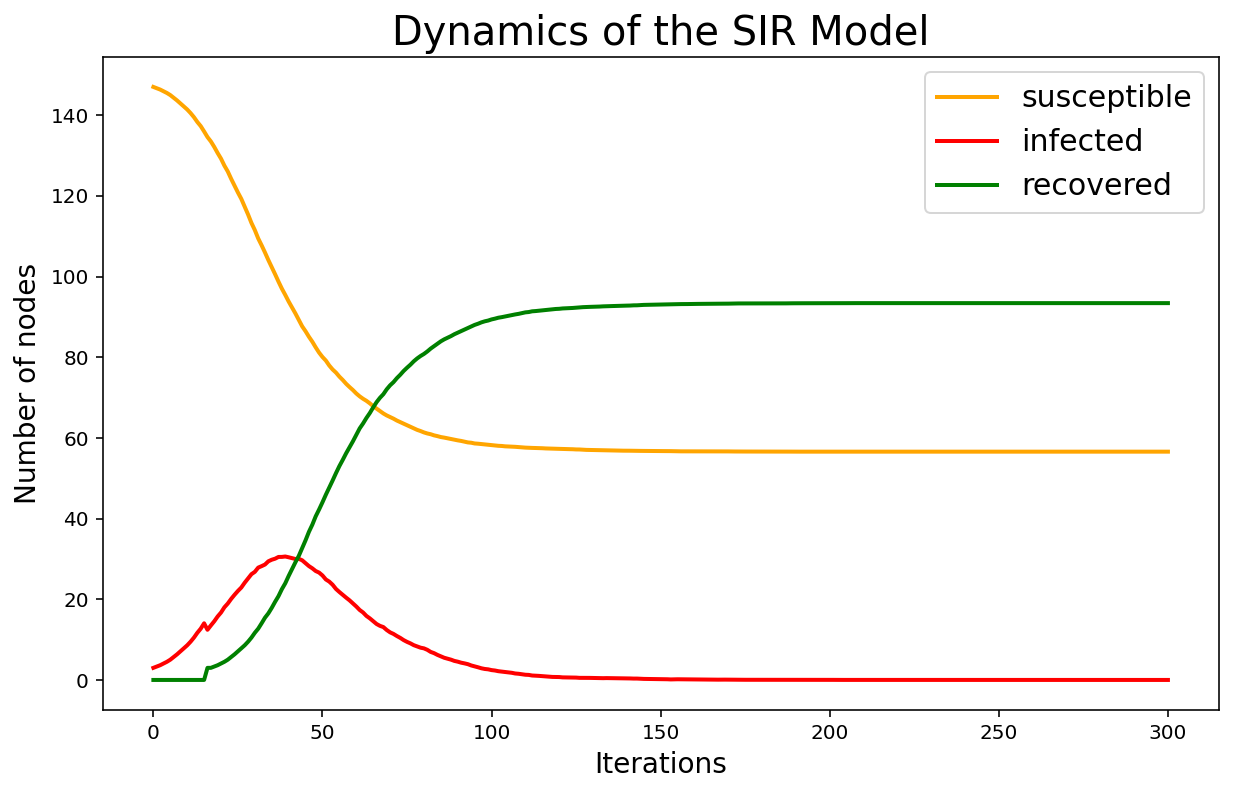

In [24]:
fig = plt.figure(figsize=(10,6))

plt.plot(average_susceptibleSIR, linewidth=2.0, c='orange', label='susceptible')
plt.plot(average_infectedSIR, linewidth=2.0, c='red', label='infected')
plt.plot(average_recoveredSIR, linewidth=2.0, c='green', label='recovered')

plt.legend(loc=1, prop={'size': 15})
plt.title('Dynamics of the SIR Model', size=20) # add titles and labels
plt.xlabel('Iterations', size=14)
plt.ylabel('Number of nodes', size=14) 

plt.show()

In [25]:
def SIR_SecondWave(G, initial_infected, beta,  beta2, t_simulation, recovery_time):
    """This model incorporates a second wave of the infection. At day 100, a new variant infects 30 people in the
       system. The new variant is transmitted more easily, with beta2 = 0.02.
       beta2: transmission probability of thr new variant"""
    
    for u in G.nodes():
        G.nodes[u]["state"] = 'S' # each node is susceptible (S) to the disease
        G.nodes[u]["TimeInfected"] = -1 # because each node has not been infected
        G.nodes[u]["neighbours"] = [n for n in G.neighbors(u)] # each node is influenced by its direct neighbours
        G.nodes[u]["new_state"] = 'stay_S' # this governs changes in the state of nodes

    # for the nodes that are initally set to be infected, we change their state and their TimeInfected
    for u in initial_infecteds:
        G.nodes[u]["state"] = 'I'
        G.nodes[u]["new_state"] = 'stay_I'
        G.nodes[u]["TimeInfected"] = 0

    # create dictionaries to store the state and time infected of each node
    state_over_time = {}
    time_over_time = {}
    # save the initial state of the system at t=0
    state = []
    for i in G.nodes():
        state.append(G.nodes[i]["state"])
    state_over_time[0] = state
    # save the time infected of each node at t=0
    time = []
    for i in G.nodes():
        time.append(G.nodes[i]["TimeInfected"])
    time_over_time[0] = time

    # running simulation
    for t in range(1,100+1): # over 100 iterations (includes day 100)
        # review the infected nodes
        for u in G.nodes:
            if G.nodes[u]["state"] == 'I':
                if G.nodes[u]["TimeInfected"] < recovery_time: 
                    G.nodes[u]["TimeInfected"] += 1
                else:
                    G.nodes[u]["new_state"] = 'become_R' #"recovered"

        # review the susceptible nodes    
        for u in G.nodes:
            if G.nodes[u]["state"] == 'S':
                for n in G.nodes[u]["neighbours"]:
                    if G.nodes[n]["state"] == 'I': # if neighbour is infected
                        if np.random.rand() < beta: # beta possbility of becoming infected
                            G.nodes[u]["new_state"] = 'become_I'

        # alter the state of the nodes
        for u in G.nodes:
            if G.nodes[u]["new_state"] == 'become_R': # recovered nodes
                G.nodes[u]["state"] = 'R'
                G.nodes[u]["new_state"] = 'stay_R' 

            if G.nodes[u]["new_state"] == 'become_I': # infected nodes
                G.nodes[u]["state"] = 'I'
                G.nodes[u]["new_state"] = 'stay_I'
                G.nodes[u]["TimeInfected"] = 0

        # save the state of the system to a list
        state = []
        for i in G.nodes():
            state.append(G.nodes[i]["state"])
        state_over_time[t] = state

        time = []
        for i in G.nodes():
            time.append(G.nodes[i]["TimeInfected"])
        time_over_time[t] = time

    # On day 100, 30 nodes are infected. We add this effect to the current state at t=100
    Reinfected = random.sample(G.nodes(), 30) # Take a random sample of the nodes
    for r in Reinfected:
        if G.nodes()[r]["state"] == 'S': # susceptible nodes become infected
            G.nodes[r]["new_state"] = 'become_I'
        if G.nodes()[r]["state"] == 'I': # infected nodes have their time infected set to 0
            G.nodes[r]["TimeInfected"] = 0

    # alter the state of the nodes
    for u in G.nodes:
        if G.nodes[u]["new_state"] == 'become_I': # infected nodes
            G.nodes[u]["state"] = 'I'
            G.nodes[u]["new_state"] = 'stay_I'
            G.nodes[u]["TimeInfected"] = 0

    # save the state of the system to a list
    state = []
    for i in G.nodes():
        state.append(G.nodes[i]["state"])
    state_over_time[100] = state # the state at t=100 is saved

    time = []
    for i in G.nodes():
        time.append(G.nodes[i]["TimeInfected"])
    time_over_time[100] = time # the time state of the nodes at t=100 is saved

    # run the simulation over the remaining 200 iterations
    for t in range(101,300+1): 
        # review the infected nodes
        for u in G.nodes:
            if G.nodes[u]["state"] == 'I':
                if G.nodes[u]["TimeInfected"] < recovery_time: 
                    G.nodes[u]["TimeInfected"] += 1
                else:
                    G.nodes[u]["new_state"] = 'become_R' #"recovered"

        # review the susceptible nodes    
        for u in G.nodes:
            if G.nodes[u]["state"] == 'S':
                for n in G.nodes[u]["neighbours"]:
                    if G.nodes[n]["state"] == 'I': # if neighbour is infected
                        if np.random.rand() < beta2: # beta2 possbility of becoming infected
                            G.nodes[u]["new_state"] = 'become_I'

        # alter the state of the nodes
        for u in G.nodes:
            if G.nodes[u]["new_state"] == 'become_R': # recovered nodes
                G.nodes[u]["state"] = 'R'
                G.nodes[u]["new_state"] = 'stay_R' 

            if G.nodes[u]["new_state"] == 'become_I': # infected nodes
                G.nodes[u]["state"] = 'I'
                G.nodes[u]["new_state"] = 'stay_I'
                G.nodes[u]["TimeInfected"] = 0

        # save the state of the system to a list
        state = []
        for i in G.nodes():
            state.append(G.nodes[i]["state"])
        state_over_time[t] = state

        time = []
        for i in G.nodes():
            time.append(G.nodes[i]["TimeInfected"])
        time_over_time[t] = time
    return state_over_time

In [26]:
"""Using the SIR_SecondWave model, the system is evaluated 100 times under different starting nodes. The average 
   number of susceptible, infected and recovered nodes at each time step of the system is stored."""

num_simulations = 100 # number of times the system will be run in order to obtain an average
# these are the inputs into the SIR_model
beta = 0.005
beta2 = 0.02
t_simulation = 300
recovery_time = 15

# the number of S, I and R nodes over time will be saved to these lists, each time we run the model
all_susceptible = []
all_infected = []
all_recovered = []

for i in range(0,num_simulations): # iterate over the number of times we want to run the model
    initial_infecteds = random.sample(Gx.nodes(), 3) # choose 3 random starting nodes 
    SI_one_iter = SIR_SecondWave(Gx, initial_infecteds, beta, beta2, t_simulation, recovery_time) # run the model
    # count the number of S, I  and R nodes at each iteration of the model
    infected = []
    susceptible = []
    recovered = []
    for i in SI_one_iter.values():
        infected.append(i.count('I'))
        susceptible.append(i.count('S'))
        recovered.append(i.count('R'))
    # store the model dynamics
    all_susceptible.append(susceptible)
    all_infected.append(infected)
    all_recovered.append(recovered)
    
    
average_susceptibleSW = []
average_infectedSW = []
average_recoveredSW = []

# obtain an average of the number of S, I and R nodes at each iteration
for j in range(0,len(all_susceptible[0])): # iterate over each time iteration 
    total_susceptible = 0
    total_infected = 0
    total_recovered = 0
    for i in range(len(all_susceptible)): # iterate over each model
        total_susceptible += all_susceptible[i][j]
        total_infected += all_infected[i][j]
        total_recovered += all_recovered[i][j]
    average_susceptibleSW.append(total_susceptible/len(all_susceptible)) # divide by number of models to obtain average
    average_infectedSW.append(total_infected/len(all_infected))
    average_recoveredSW.append(total_recovered/len(all_recovered))

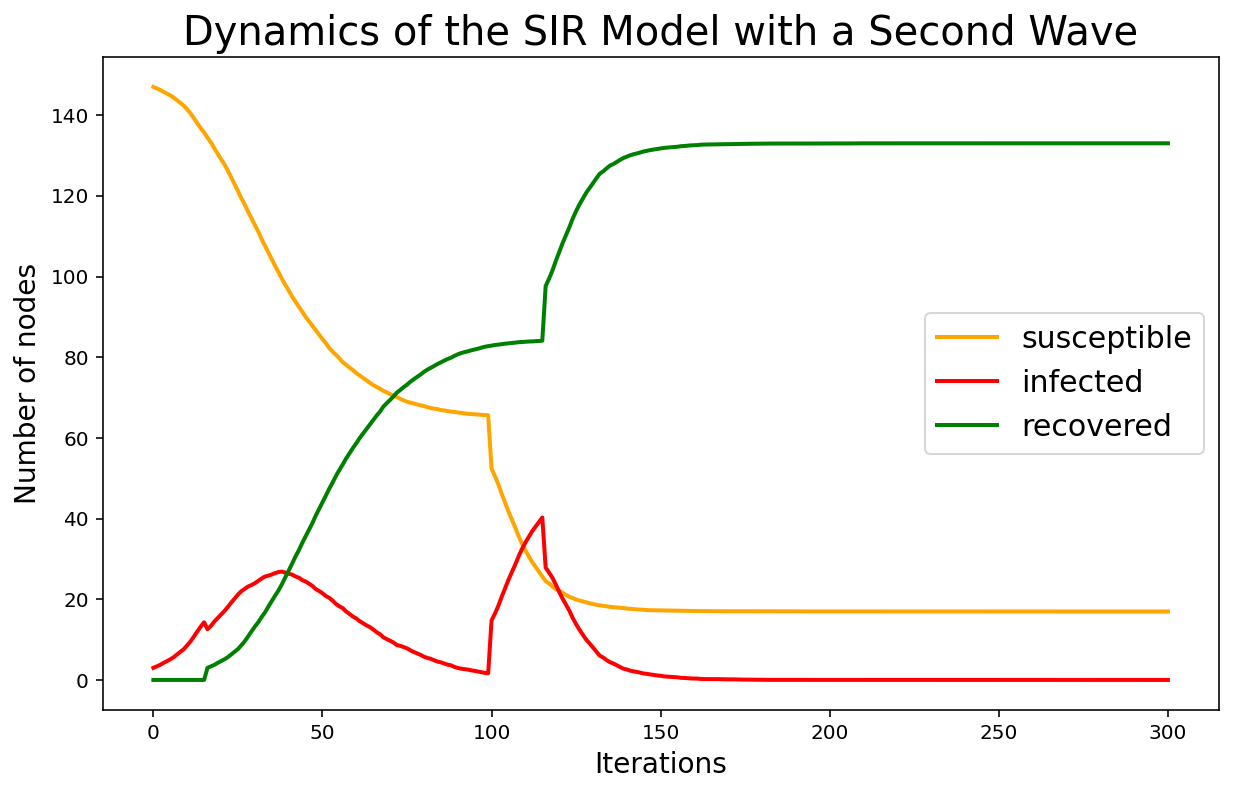

In [27]:
fig = plt.figure(figsize=(10,6))

plt.plot(average_susceptibleSW, linewidth=2.0, c='orange', label='susceptible')
plt.plot(average_infectedSW, linewidth=2.0, c='red', label='infected')
plt.plot(average_recoveredSW, linewidth=2.0, c='green', label='recovered')

plt.legend(loc=5, prop={'size': 15})
plt.title('Dynamics of the SIR Model with a Second Wave', size=20) # add titles and labels
plt.xlabel('Iterations', size=14)
plt.ylabel('Number of nodes', size=14) 

plt.show()

# 3d) Remarks

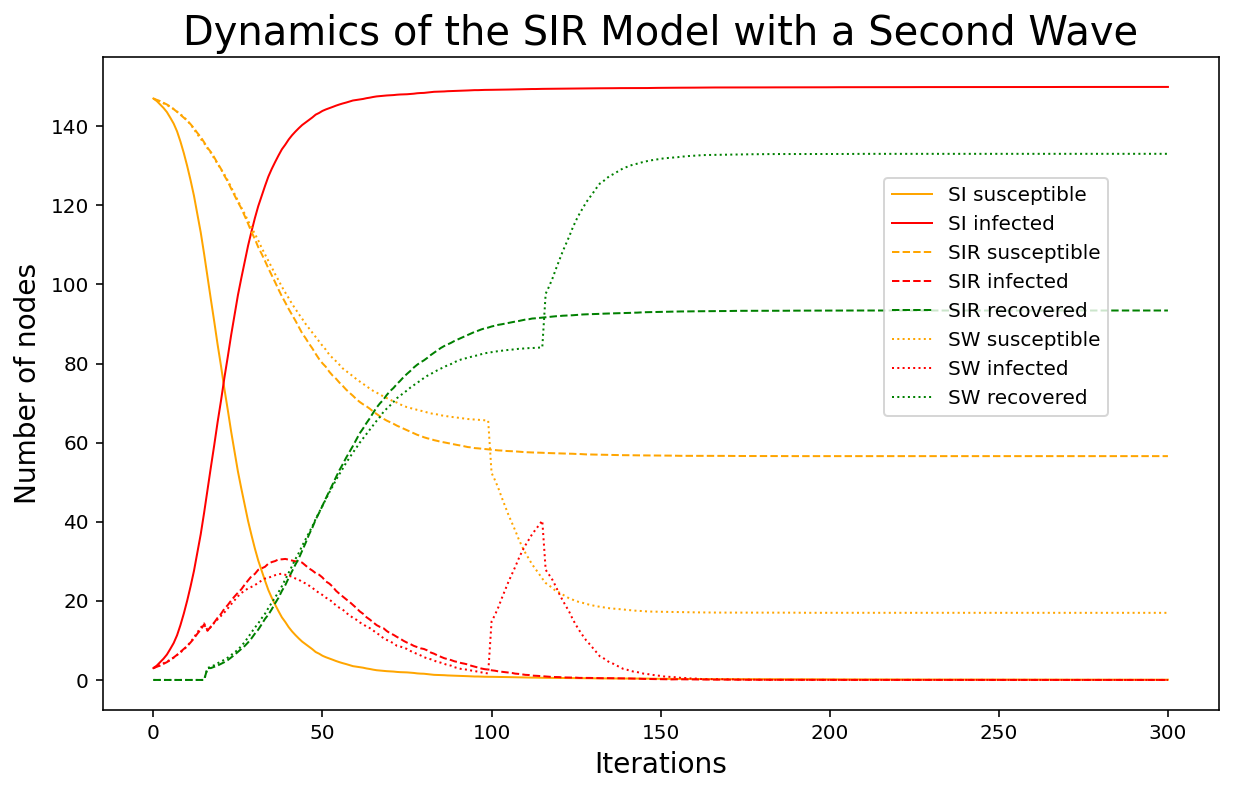

In [28]:
fig = plt.figure(figsize=(10,6))

plt.plot(average_susceptibleSI, linewidth=1.0, c='orange', label='SI susceptible')
plt.plot(average_infectedSI, linewidth=1.0, c='red', label='SI infected')

plt.plot(average_susceptibleSIR, '--', linewidth=1.0, c='orange', label='SIR susceptible')
plt.plot(average_infectedSIR, '--', linewidth=1.0, c='red', label='SIR infected')
plt.plot(average_recoveredSIR, '--', linewidth=1.0, c='green', label='SIR recovered')

plt.plot(average_susceptibleSW, ':', linewidth=1.0, c='orange', label='SW susceptible')
plt.plot(average_infectedSW, ':', linewidth=1.0, c='red', label='SW infected')
plt.plot(average_recoveredSW, ':', linewidth=1.0, c='green', label='SW recovered')


plt.legend(loc=(0.7,0.45), prop={'size': 10})
plt.title('Dynamics of the SIR Model with a Second Wave', size=20) # add titles and labels
plt.xlabel('Iterations', size=14)
plt.ylabel('Number of nodes', size=14) 

plt.show()

In [29]:
print('Stats that are referenced to in the remarks')
print('')
print(average_susceptibleSI[-1]) # obtaining the last data point
print(average_infectedSI[-1])
print('____')
print(average_susceptibleSIR[-1])
print(average_recoveredSIR[-1])
print(average_infectedSIR[40]) # obtaining the peak at iteration number 40
print('____')
print(average_susceptibleSW[-1])
print(average_recoveredSW[-1])

print(average_infectedSW[40])
print(average_infectedSW[115]) #  obtaining the second peak at iteration number 115

Stats that are referenced to in the remarks

0.06
149.94
____
56.59
93.41
30.41
____
16.97
133.03
26.33
40.28


The SI model was used to model a disease infecting the network that had a transmission rate of 0.01. In this model, nodes are either susceptible to the disease or infected by the disease. In this case, every node was infected by the disease after around 60 iterations.

The SIR model has a more complex behaviour as nodes recover from the disease after 15 days. This model was used to model a disease that has a transmission rate of 0.005. As the disease entered the network, the number of infected nodes increased until the 40th iteration, at which 30 nodes were infected. After this time, number of infected nodes started to decrease until it reached 0. The number of susceptible and recovered nodes reached a stable equilibrium at 58 and 92 respectively. 

The Second Wave SIR model behaved almost identically to the SI model until the 100th iteration as they both had a transmission rate of 0.005. On the 100th day, a new variant of the disease infected 30 random nodes, the new variant also had a higher transmission rate of 0.02. This caused the number of infected nodes to rise until it peaked at 35 on the 115th day. The number of infected people then slowly decreased to 0 and the number of susceptible and recovered nodes reached an equalibrium of 18 and 131 respectively. 